# About the notebook

In [3]:
### import libraries
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(suppressWarnings(library(ggridges)))
suppressMessages(suppressWarnings(library(MPSK)))
suppressMessages(suppressWarnings(library(tsne)))
suppressMessages(suppressWarnings(library(pheatmap)))
suppressMessages(suppressWarnings(library(RColorBrewer)))
suppressMessages(suppressWarnings(library(flowCore)))
suppressMessages(suppressWarnings(library(flowStats)))
suppressMessages(suppressWarnings(library(flowViz)))
suppressMessages(suppressWarnings(library(flowMatch)))

### set directories
#dat_dir01 = "/data/SMPK"
dat_dir = "/data/clintko/SMPK"

# Import data

In [4]:
dat_mpsk_raw = read_delim(file.path(dat_dir, "ep8cs_prior50_dat_mpsk_raw.txt"),  delim = "\t")
dat_mpsk_cal = read_delim(file.path(dat_dir, "ep8cs_prior50_dat_mpsk_cal.txt"),  delim = "\t")

Parsed with column specification:
cols(
  sample = col_character(),
  cluster = col_integer(),
  `FSC-A` = col_double(),
  `SSC-A` = col_double(),
  Aqua = col_double(),
  CD3 = col_double(),
  CD4 = col_double(),
  CD8 = col_double(),
  TNFa = col_double(),
  IL2 = col_double(),
  IFNg = col_double(),
  CD107a = col_double()
)
Parsed with column specification:
cols(
  sample = col_character(),
  cluster = col_integer(),
  `FSC-A` = col_double(),
  `SSC-A` = col_double(),
  Aqua = col_double(),
  CD3 = col_double(),
  CD4 = col_double(),
  CD8 = col_double(),
  TNFa = col_double(),
  IL2 = col_double(),
  IFNg = col_double(),
  CD107a = col_double()
)


# compare MPSK calibration with batch removal methods
- MPSK calibration
- GaussNorm Per-channel basis calibration

In [7]:
dat = dat_mpsk_raw
idx_sample = "01"

    mat = dat %>% 
        dplyr::filter(sample == idx_sample) %>% 
        dplyr::select(-sample, -cluster) %>% 
        as.matrix

head(mat)

FSC-A,SSC-A,Aqua,CD3,CD4,CD8,TNFa,IL2,IFNg,CD107a
-1.1416363,-0.09986633,-0.4210673,0.7761014,2.2731346,0.6444498,-0.1937829,-0.02015737,-0.27344867,0.60710339
-0.8405893,-0.73858079,1.2407957,-0.4222472,-0.5658801,0.6557209,-0.6118518,-0.02377409,-0.34964856,-0.03757027
0.5107179,-0.84609384,-1.0598249,-0.3661789,-0.5889247,-1.8527354,-1.1840413,-0.03447264,-0.42590688,-0.02672243
-1.5681802,-0.57996979,-0.5588165,0.2319850,1.8415205,-0.1502302,-0.5595654,0.02146696,-0.51009832,-0.01391902
-1.5371229,0.32463843,-0.2535651,-0.6772130,2.0872188,-1.3166316,-0.6453749,-0.22168409,-0.88871667,0.15053694
-0.2959737,-0.29703637,-0.2005701,-0.6302307,0.4919176,-0.8454200,-0.2646515,2.44124150,0.02647195,0.33899091


In [8]:
### calculate the range of each marker 
    df_range = apply(mat, 2, function(x){
        x_min   = min(x)
        x_max   = max(x)
        x_range = x_max - x_min
        res = c(x_range, x_min, x_max)
        names(res) = c("range", "minRange", "maxRange")
        return(res)
    })   
    df_range = df_range %>% t %>% as.data.frame
df_range

,range,minRange,maxRange
FSC-A,5.323933,-2.368027,2.955907
SSC-A,5.528796,-1.355169,4.173627
Aqua,4.109950,-1.631503,2.478447
CD3,6.536353,-3.186924,3.349429
CD4,5.743360,-1.056085,4.687275
CD8,6.088902,-2.861287,3.227615
TNFa,11.722307,-3.966741,7.755566
IL2,6.092731,-1.726946,4.365785
IFNg,9.065996,-4.794087,4.271909
CD107a,9.560700,-3.030371,6.530329


In [9]:
    ### combine marker ranges and names into AnnotatedDataFrame
    df_annot = data.frame(name = colnames(mat), desc = colnames(mat))
    df_annot = bind_cols(df_annot, df_range)  
    rownames(df_annot) = df_annot$name
    df_annot = Biobase::AnnotatedDataFrame(df_annot)

    ### create flowFrame from the intensity matrix and annotated dataframe
    frame = flowFrame(exprs = mat, parameters = df_annot)
    identifier(frame) = paste0("Sample ", idx_sample)

In [10]:
frame

flowFrame object 'Sample 01'
with 10000 cells and 10 observables:
         name   desc     range  minRange maxRange
FSC-A   FSC-A  FSC-A  5.323933 -2.368027 2.955907
SSC-A   SSC-A  SSC-A  5.528796 -1.355169 4.173627
Aqua     Aqua   Aqua  4.109950 -1.631503 2.478447
CD3       CD3    CD3  6.536353 -3.186924 3.349429
CD4       CD4    CD4  5.743360 -1.056085 4.687275
CD8       CD8    CD8  6.088902 -2.861287 3.227615
TNFa     TNFa   TNFa 11.722307 -3.966741 7.755566
IL2       IL2    IL2  6.092731 -1.726946 4.365785
IFNg     IFNg   IFNg  9.065996 -4.794087 4.271909
CD107a CD107a CD107a  9.560700 -3.030371 6.530329
1 keywords are stored in the 'description' slot

Helper function for create flowFrame object

In [11]:
create_frame = function(dat, idx_sample){
    # create flowFrame object from input dataframe (dat)
    #####################################
    ### get one sample
    mat = dat %>% 
        dplyr::filter(sample == idx_sample) %>% 
        dplyr::select(-sample, -cluster) %>% 
        as.matrix
    
    ### calculate the range of each marker 
    df_range = apply(mat, 2, function(x){
        x_min   = min(x)
        x_max   = max(x)
        x_range = x_max - x_min
        res = c(x_range, x_min, x_max)
        names(res) = c("range", "minRange", "maxRange")
        return(res)
    })   
    df_range = df_range %>% t %>% as.data.frame

    ### combine marker ranges and names into AnnotatedDataFrame
    df_annot = data.frame(name = colnames(mat), desc = colnames(mat))
    df_annot = bind_cols(df_annot, df_range)  
    rownames(df_annot) = df_annot$name
    df_annot = Biobase::AnnotatedDataFrame(df_annot)

    ### create flowFrame from the intensity matrix and annotated dataframe
    frame = flowFrame(exprs = mat, parameters = df_annot)
    identifier(frame) = paste0("Sample ", idx_sample)
    
    return(frame)
} # end function

Create flowSet object from a list of flowFrame objects

In [24]:
idx_sample = unique(dat_mpsk_raw$sample)
print(idx_sample)

 [1] "01" "02" "03" "04" "05" "06" "07" "08" "09" "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18"


In [25]:
marker_name = colnames(dat_mpsk_raw)[-c(1, 2)]
print(marker_name)

 [1] "FSC-A"  "SSC-A"  "Aqua"   "CD3"    "CD4"    "CD8"    "TNFa"   "IL2"   
 [9] "IFNg"   "CD107a"


In [21]:
### Create flowSet object of raw Y and C
dat = dat_mpsk_raw
lst = lapply(idx_sample, function(idx){create_frame(dat, idx)})
names(lst) = sapply(lst, identifier)
set_raw = flowSet(lst)

### Create flowSet object of Y_cal and C
dat = dat_mpsk_cal
lst = lapply(idx_sample, function(idx){create_frame(dat, idx)})
names(lst) = sapply(lst, identifier)
set_cal = flowSet(lst)

### Normalized by Per-channel basis calibration
set_norm = gaussNorm(set_raw, channel.names = marker_name)


Adjusting the distance between landmarks
..................


**Visualization**

Raw data

Picking joint bandwidth of 0.114
Picking joint bandwidth of 0.0773
Picking joint bandwidth of 0.137
Picking joint bandwidth of 0.136
Picking joint bandwidth of 0.119
Picking joint bandwidth of 0.131
Picking joint bandwidth of 0.11
Picking joint bandwidth of 0.119
Picking joint bandwidth of 0.0622
Picking joint bandwidth of 0.114


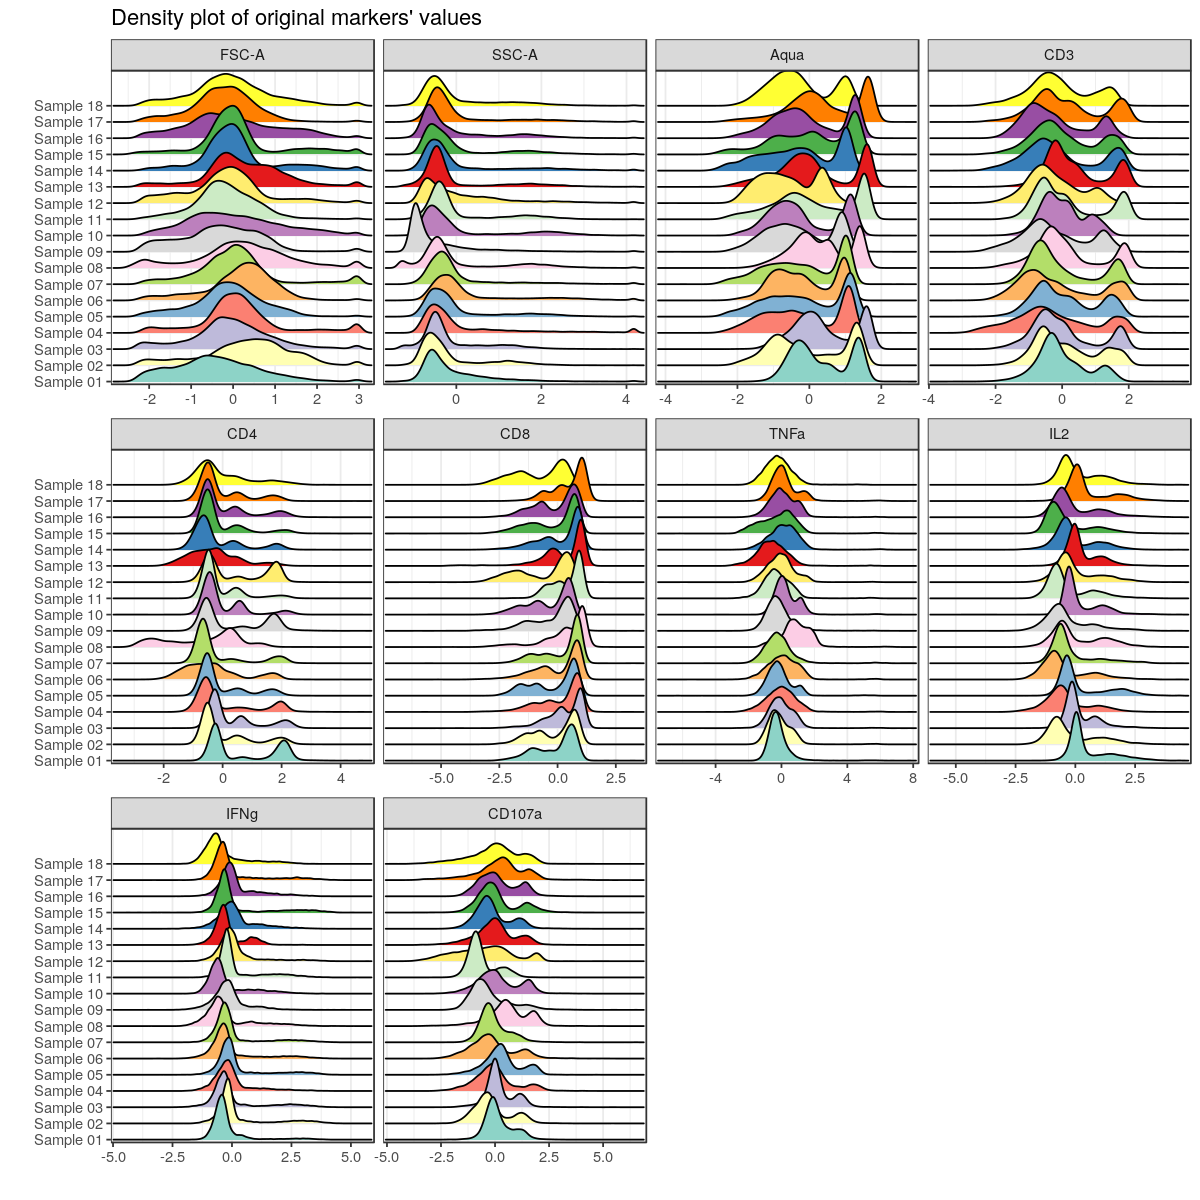

In [28]:
### set data and factor levels
dat = dat_mpsk_raw %>% gather(marker, value, -sample, -cluster)
dat$sample = paste("Sample", dat$sample)
dat$marker = factor(dat$marker, levels = marker_name)

### set manual colors
cols = c(brewer.pal(12, "Set3"), brewer.pal(6, "Set1"))
names(cols) = paste("Sample", idx_sample)

### set density ggplot
gp = ggplot(dat, aes(x = value, y = sample, fill = sample)) +
    geom_density_ridges(scale = 3) + 
    scale_fill_manual(values = cols) +
    scale_y_discrete(expand=c(0.01, 0)) +
    scale_x_continuous(expand=c(0.01, 0)) +
    facet_wrap(~marker, scales = "free_x") +
    theme_bw() +
    theme(legend.position = "none") +
    labs(y = "", x = "", title = "Density plot of original markers' values")
    
### visualize the plot
options(repr.plot.width = 10, repr.plot.height = 10)
print(gp)

Picking joint bandwidth of 0.114
Picking joint bandwidth of 0.0773
Picking joint bandwidth of 0.137
Picking joint bandwidth of 0.136
Picking joint bandwidth of 0.119
Picking joint bandwidth of 0.131
Picking joint bandwidth of 0.11
Picking joint bandwidth of 0.119
Picking joint bandwidth of 0.0622
Picking joint bandwidth of 0.114


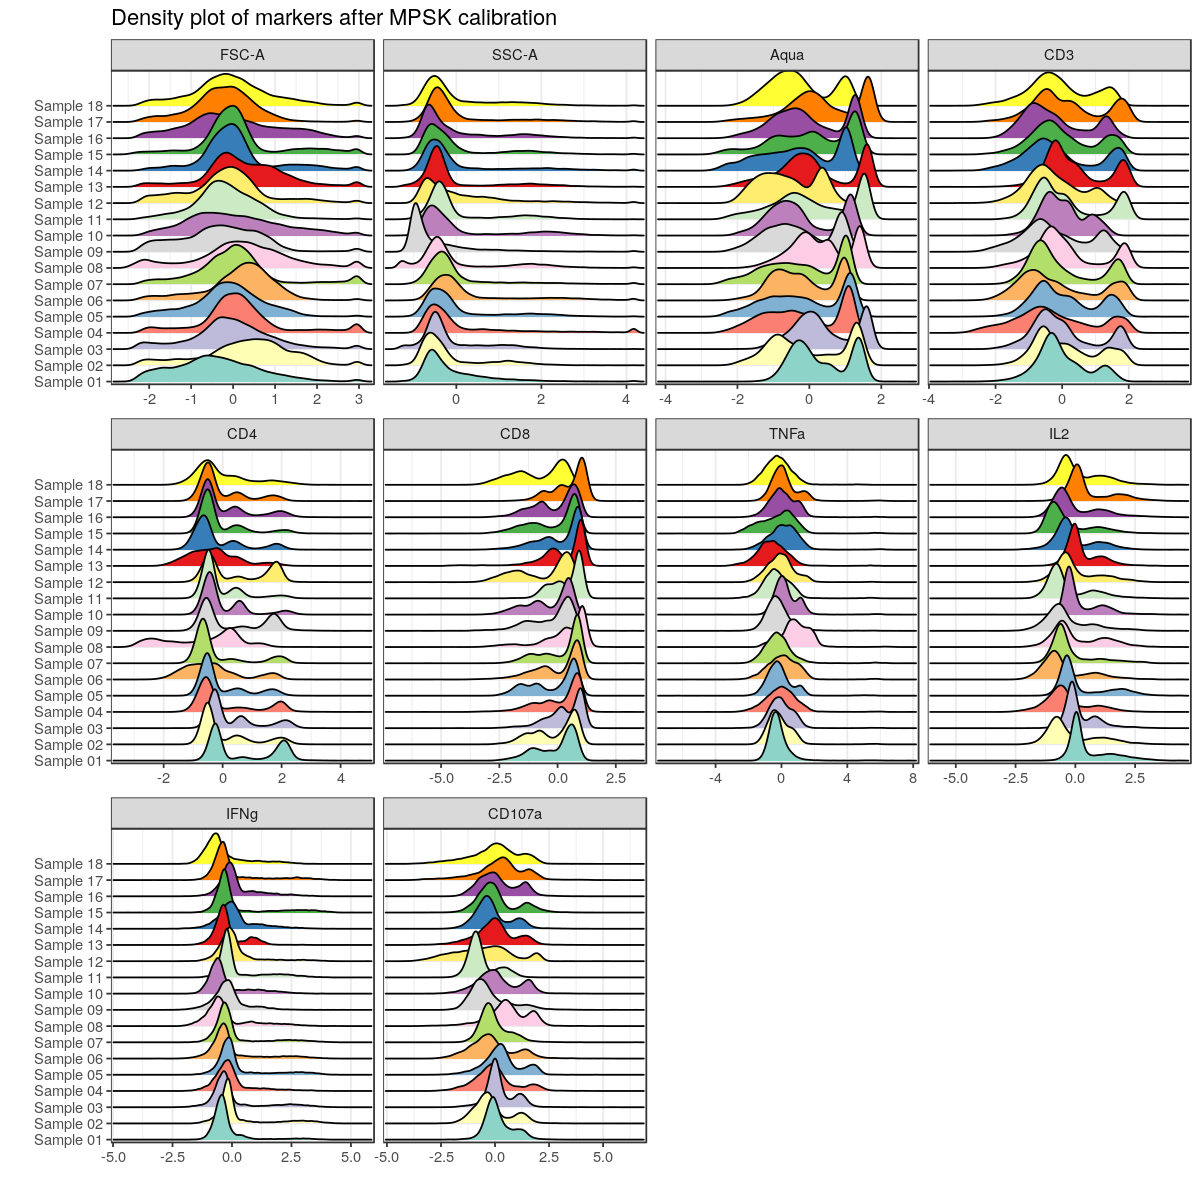

In [29]:
### set data and factor levels
dat = dat_mpsk_cal %>% gather(marker, value, -sample, -cluster)
dat$sample = paste("Sample", dat$sample)
dat$marker = factor(dat$marker, levels = marker_name)

### set manual colors
cols = c(brewer.pal(12, "Set3"), brewer.pal(6, "Set1"))
names(cols) = paste("Sample", idx_sample)

### set density ggplot
gp = ggplot(dat, aes(x = value, y = sample, fill = sample)) +
    geom_density_ridges(scale = 3) + 
    scale_fill_manual(values = cols) +
    scale_y_discrete(expand=c(0.01, 0)) +
    scale_x_continuous(expand=c(0.01, 0)) +
    facet_wrap(~marker, scales = "free_x") +
    theme_bw() +
    theme(legend.position = "none") +
    labs(y = "", x = "", title = "Density plot of markers after MPSK calibration")
    
### visualize the plot
options(repr.plot.width = 10, repr.plot.height = 10)
print(gp)

In [30]:
### set data and factor levels
dat = lapply(1:length(set_norm$flowset), function(idx){
    frame = set_norm$flowset[[idx]]
    mat   = exprs(frame) %>% as.tibble
    idx   = str_pad(idx, 2, pad = "0")
    dat   = tibble(sample = rep(idx, nrow(mat)))
    dat   = bind_cols(dat, mat)
    return(dat)
}) # end lapply
dat = do.call(bind_rows, dat)
dat_gaussnorm = dat

#unique(dat_gaussnorm$sample)
head(dat_gaussnorm)

sample,FSC-A,SSC-A,Aqua,CD3,CD4,CD8,TNFa,IL2,IFNg,CD107a
01,-0.6347897,-0.05725495,-0.5841997,0.9057631,0.8624611,0.82544730,-0.0646321,-0.5417764,0.002922948,0.843809002
01,-0.3337427,-0.69596941,1.0780301,-0.6396301,-0.9608552,0.83648958,-0.4827010,-0.5454269,-0.102532512,-0.012404418
01,1.0175645,-0.80348247,-1.2228949,-0.5834939,-0.9826067,-1.53960754,-1.0548905,-0.5562218,-0.200782508,-0.000150287
01,-1.0613336,-0.53735841,-0.7219453,0.1307065,0.4782163,0.09460223,-0.4304146,-0.4997147,-0.301005899,0.014428597
01,-1.0302762,0.36724981,-0.4166907,-0.8753860,0.6843313,-0.98263009,-0.5162241,-0.7442086,-0.662089979,0.212854595
01,0.2108729,-0.25442499,-0.3636909,-0.8340660,-0.2627146,-0.52593850,-0.1355007,1.9556850,0.482898576,0.463610339


Picking joint bandwidth of 0.114
Picking joint bandwidth of 0.0782
Picking joint bandwidth of 0.136
Picking joint bandwidth of 0.141
Picking joint bandwidth of 0.1
Picking joint bandwidth of 0.134
Picking joint bandwidth of 0.11
Picking joint bandwidth of 0.117
Picking joint bandwidth of 0.0642
Picking joint bandwidth of 0.115


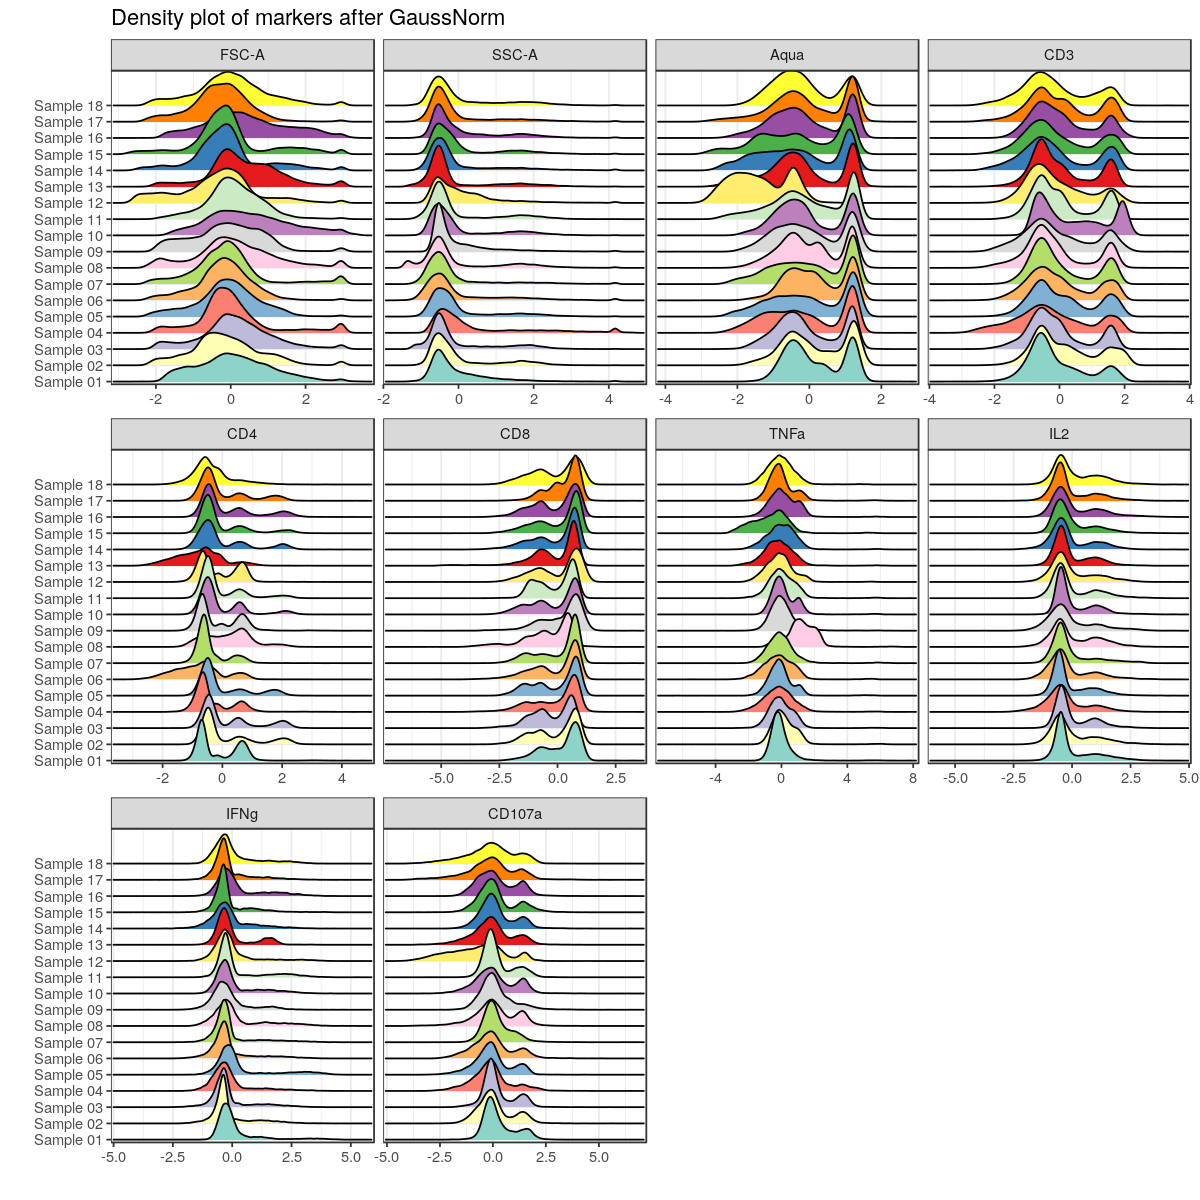

In [32]:
### set data and factor levels
dat = dat_gaussnorm %>% gather(marker, value, -sample)
dat$sample = paste("Sample", dat$sample)
dat$marker = factor(dat$marker, levels = marker_name)

### set manual colors
cols = c(brewer.pal(12, "Set3"), brewer.pal(6, "Set1"))
names(cols) = paste("Sample", idx_sample)

### set density ggplot
gp = ggplot(dat, aes(x = value, y = sample, fill = sample)) +
    geom_density_ridges(scale = 3) + 
    scale_fill_manual(values = cols) +
    scale_y_discrete(expand=c(0.01, 0)) +
    scale_x_continuous(expand=c(0.01, 0)) +
    facet_wrap(~marker, scales = "free_x") +
    theme_bw() +
    theme(legend.position = "none") +
    labs(y = "", x = "", title = "Density plot of markers after GaussNorm")
    
### visualize the plot
options(repr.plot.width = 10, repr.plot.height = 10)
print(gp)

Recheck the plot above using the densityplot from flowViz package

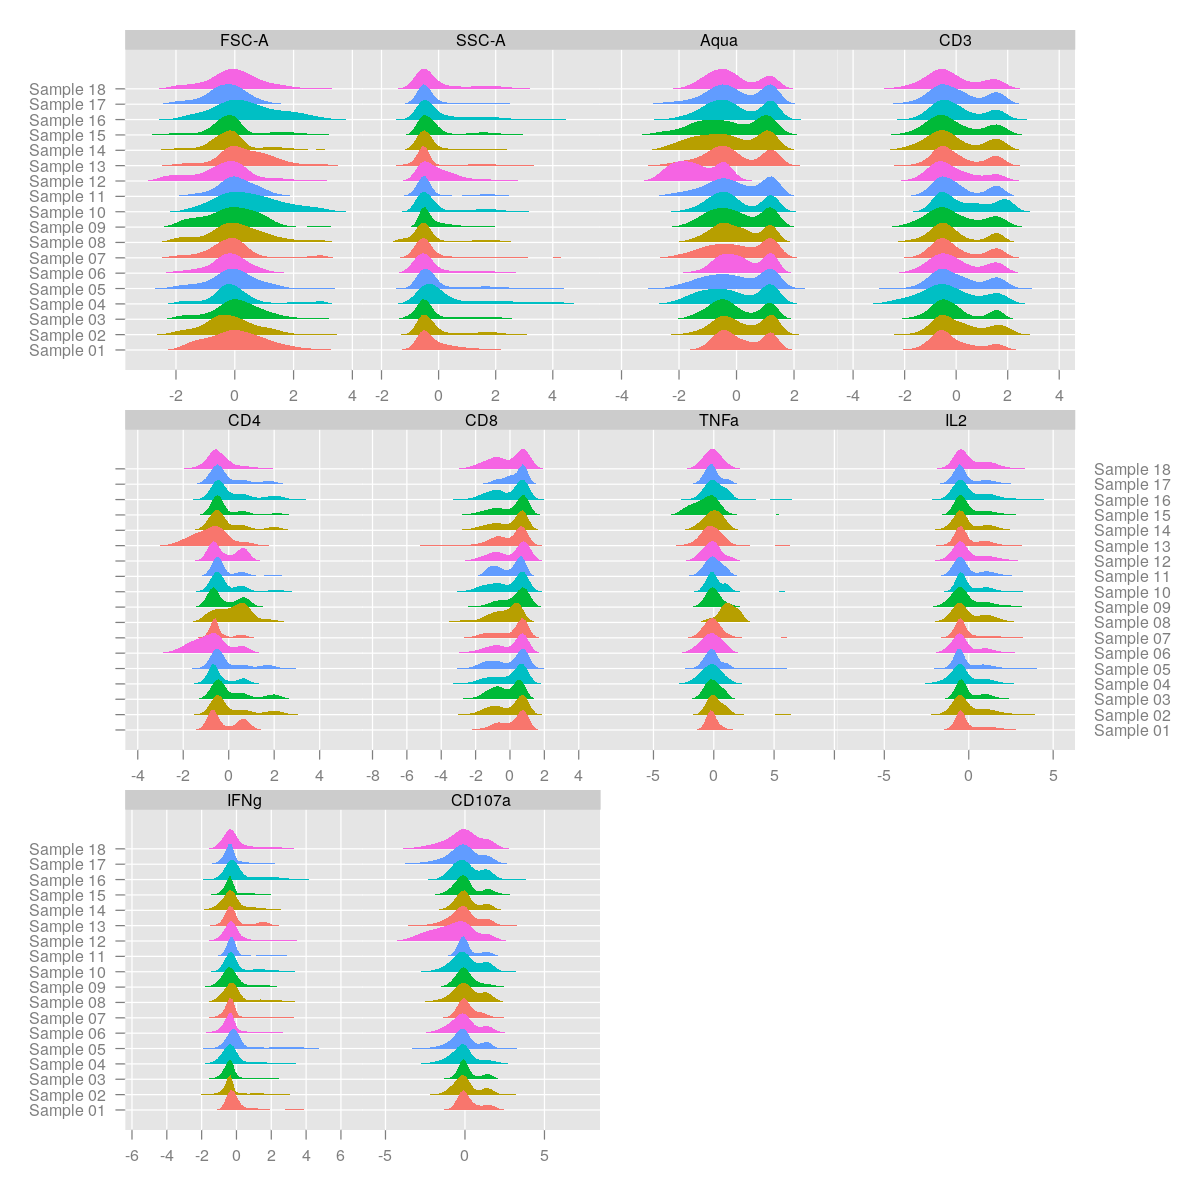

In [33]:
options(repr.plot.width = 10, repr.plot.height = 10)
densityplot(~., set_norm$flowset, channels = marker_name)

# Store the results

In [36]:
write_delim(dat_gaussnorm, file.path(dat_dir, "ep8cs_prior50_dat_gaussnorm.txt"), delim = "\t")

In [37]:
for (tmp in system(paste("ls", dat_dir), intern = TRUE)){print(tmp)}

[1] "C.txt"
[1] "ep8cs_dat_gaussnorm.txt"
[1] "ep8cs_dat_mpsk_cal.txt"
[1] "ep8cs_dat_mpsk_raw.txt"
[1] "ep8cs_mpsk_cal.RDS"
[1] "ep8cs_mpsk_chainSummary.RDS"
[1] "ep8cs_mpsk_raw_prior50.RDS"
[1] "ep8cs_mpsk_raw.RDS"
[1] "ep8cs_mpsk_relab.RDS"
[1] "ep8cs_prior50_dat_gaussnorm.txt"
[1] "ep8cs_prior50_dat_mpsk_cal.txt"
[1] "ep8cs_prior50_dat_mpsk_raw.txt"
[1] "ep8cs_tsne_gaussnorm.txt"
[1] "ep8cs_tsne_idx.txt"
[1] "ep8cs_tsne_mpsk_cal.txt"
[1] "ep8cs_tsne_raw.txt"
[1] "ep8cs_tsne_test.txt"
[1] "Y_raw.txt"
